In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
from lsst.daf.butler import Butler
import lsst.geom as geom
from astropy.io import ascii as astascii
import glob
import astropy.table as astTable
import fitsio
import healpy as hp
import numpy.lib.recfunctions as rfn
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

import lsst.afw.image as afwImage
from astropy.visualization import ZScaleInterval

# Set up the configuration
config = RingsSkyMapConfig()
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0 / 60  # degrees
config.pixelScale = 0.168  # arcsec/pixel
skymap = RingsSkyMap(config)

In [24]:
tract_id = 10045
cat_dir = os.path.join(
    os.environ['s23b'],
    "db_random",
)
cat_fname = f"{cat_dir}/{tract_id}.fits"
cat0 = fitsio.read(cat_fname)
rootdir = os.environ["s23b"]
tps = fitsio.read(
    f"{rootdir}/tracts_fdfc_v1_final.fits"
)
patch_db_list = tps["patch"][tps["tract"] == tract_id]
cat_all = []
for patch_db in patch_db_list[8:9]:
    mm = (cat0["patch"] == patch_db)
    cat = cat0[mm]
    patch_x = patch_db // 100
    patch_y = patch_db % 100
    patch_id = patch_x + patch_y * 9
    patch_info = skymap[tract_id][patch_id]
    wcs = patch_info.getWcs()
    bbox = patch_info.getOuterBBox()
    mask_dir = f"{os.environ['s23b_mask']}/{tract_id}/{patch_id}"
    mask_fname = os.path.join(mask_dir, "mask3.fits")
    bmask = fitsio.read(mask_fname)
    nim_dir = f"{os.environ['s23b_nimg']}/{tract_id}/{patch_id}/i/"
    nim_fname = glob.glob(os.path.join(nim_dir, "*.fits"))[0]
    bmask = (bmask | (fitsio.read(nim_fname) <=2).astype(np.int16))
    x, y = wcs.skyToPixelArray(
        ra=cat["ra"],
        dec=cat["dec"],
        degrees=True,
    )
    x = np.round(x - bbox.getBeginX()).astype(int)
    y = np.round(y - bbox.getBeginY()).astype(int)
    mask_int = bmask[y, x]
    cat = rfn.append_fields(
        cat, "mask", mask_int, dtypes='i4', usemask=False,
    )
    break

In [25]:
patch_db_list

array([100, 200, 308, 500, 507, 508, 600, 601, 603, 604, 605, 606, 607,
       608, 700, 701, 702, 703, 705, 706, 708, 800, 801, 802, 803, 804,
       805, 806, 807, 808], dtype='>i4')

In [26]:
y

array([2615, 2572, 1546, ..., 2624, 3013,  368])

In [27]:
np.sum(cat["mask"])

4834

In [28]:
len(cat)

12503

In [29]:
calexp_dir = f"{os.environ['s23b_calexp']}/{tract_id}/{patch_id}/i"
exp_fname = glob.glob(os.path.join(calexp_dir, "*.fits"))[0]
exposure = afwImage.ExposureF.readFits(exp_fname)
image = exposure.image.array

In [30]:
tract_id

10045

In [31]:
patch_id

33

In [33]:
msk = (cat["mask"] == 0)

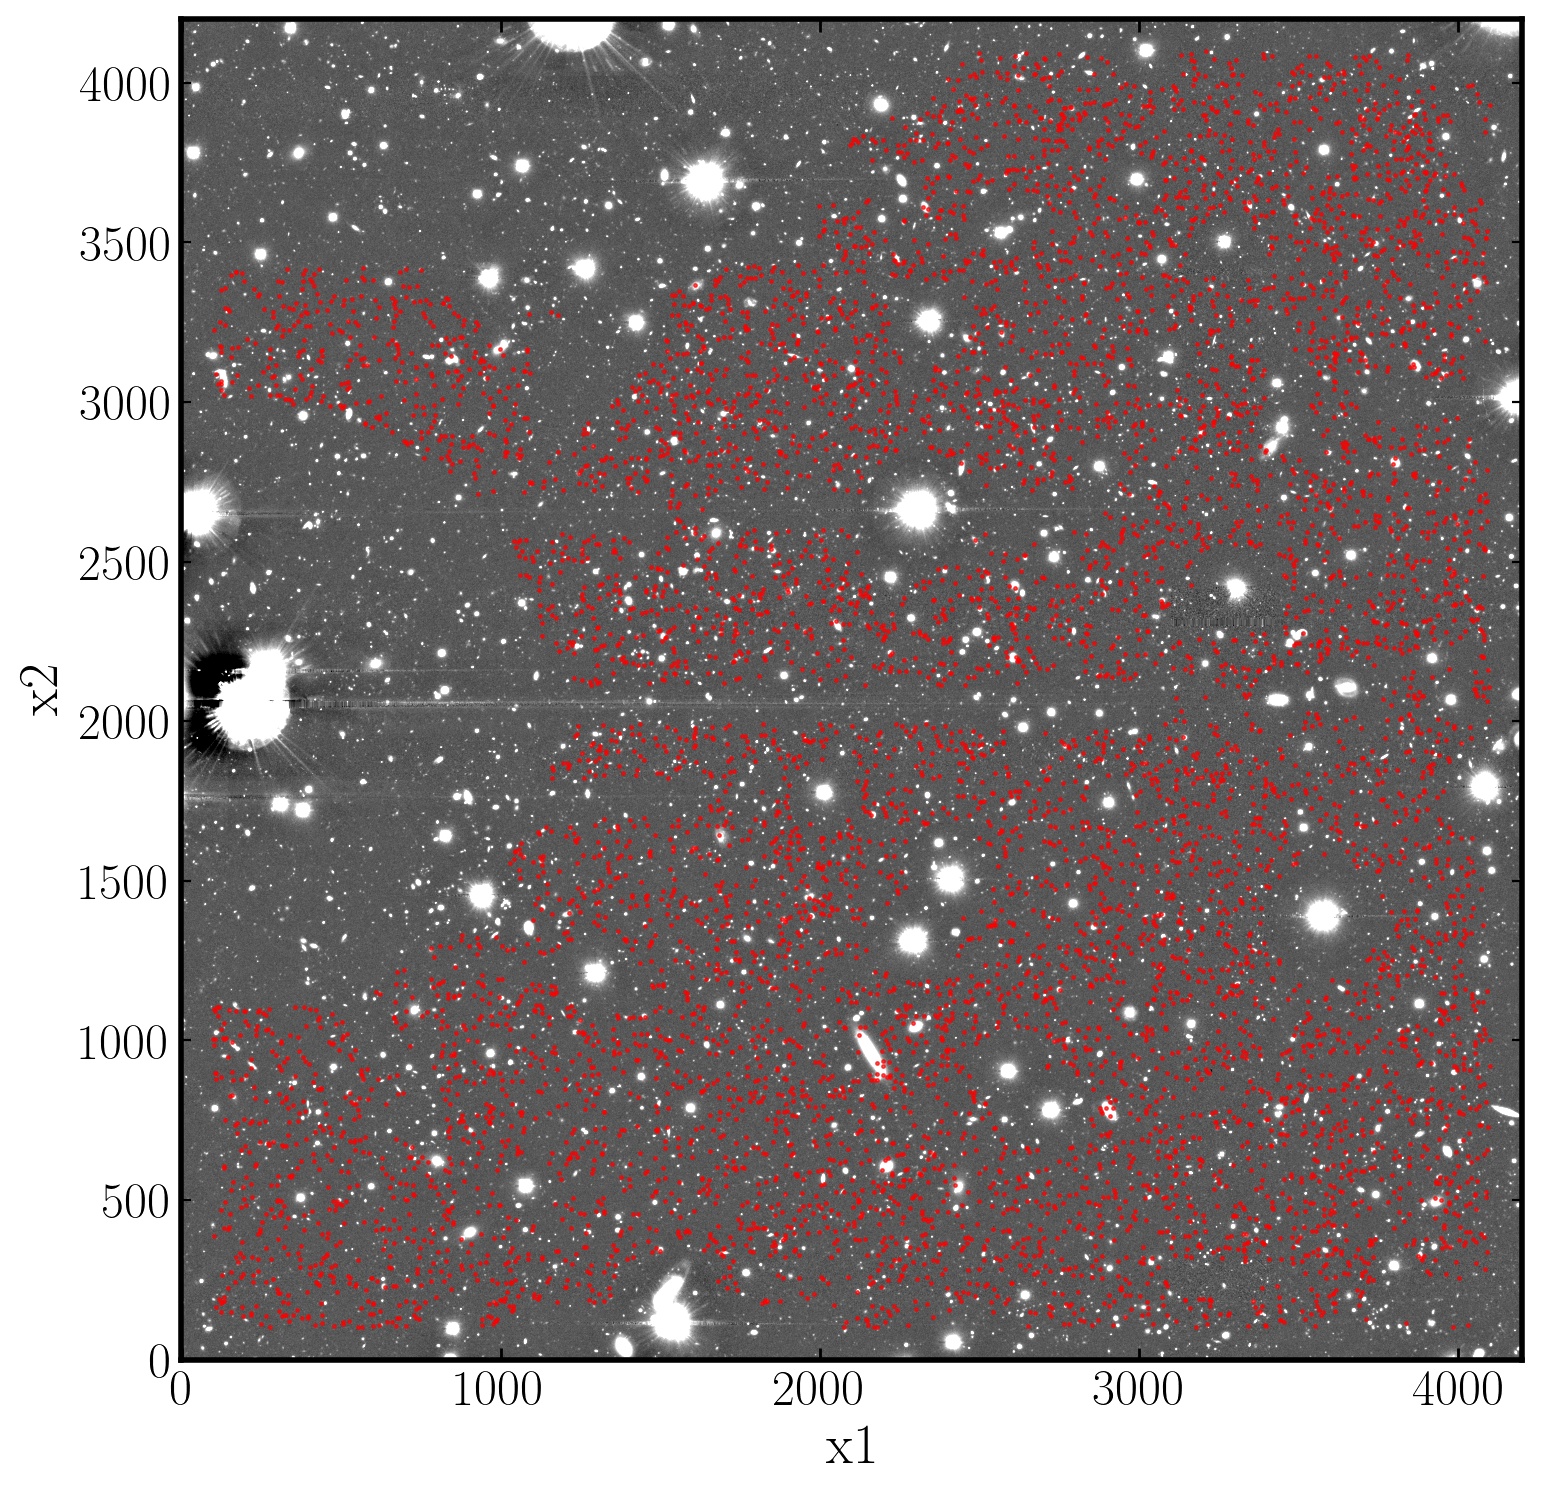

In [34]:
plt.close()
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.scatter(x[msk], y[msk], s=1.5, c='red', edgecolors='red', linewidths=0.5, alpha=0.7)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()